### MRI data analysis, sources databases, tools


1) **MRI data formats** 
2) **accessing data voxel and meta data** 
3) **visualization** 
4) **transformations** 
5) **preprocessing** 


In [ ]:
# !apt update
# !apt install -y libtiff5
# !conda install -y -c conda-forge matplotlib

In [7]:
from pydicom.data import get_testdata_files
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Image
import ipywidgets as widgets
import nibabel.freesurfer.mghformat as mgh
import nibabel as nib
import pydicom
from glob import glob
import os
import numpy as np
from nilearn.input_data import NiftiMasker
from nilearn import plotting
%matplotlib inline


## 1) MRI File Formats 

All volume-based formats store 3D or 4D arrays of voxels in some fashion with a variety of additional meta-data. Anatomical images are typically 3D while EPIs are typically 4D (x,y,z, and time).


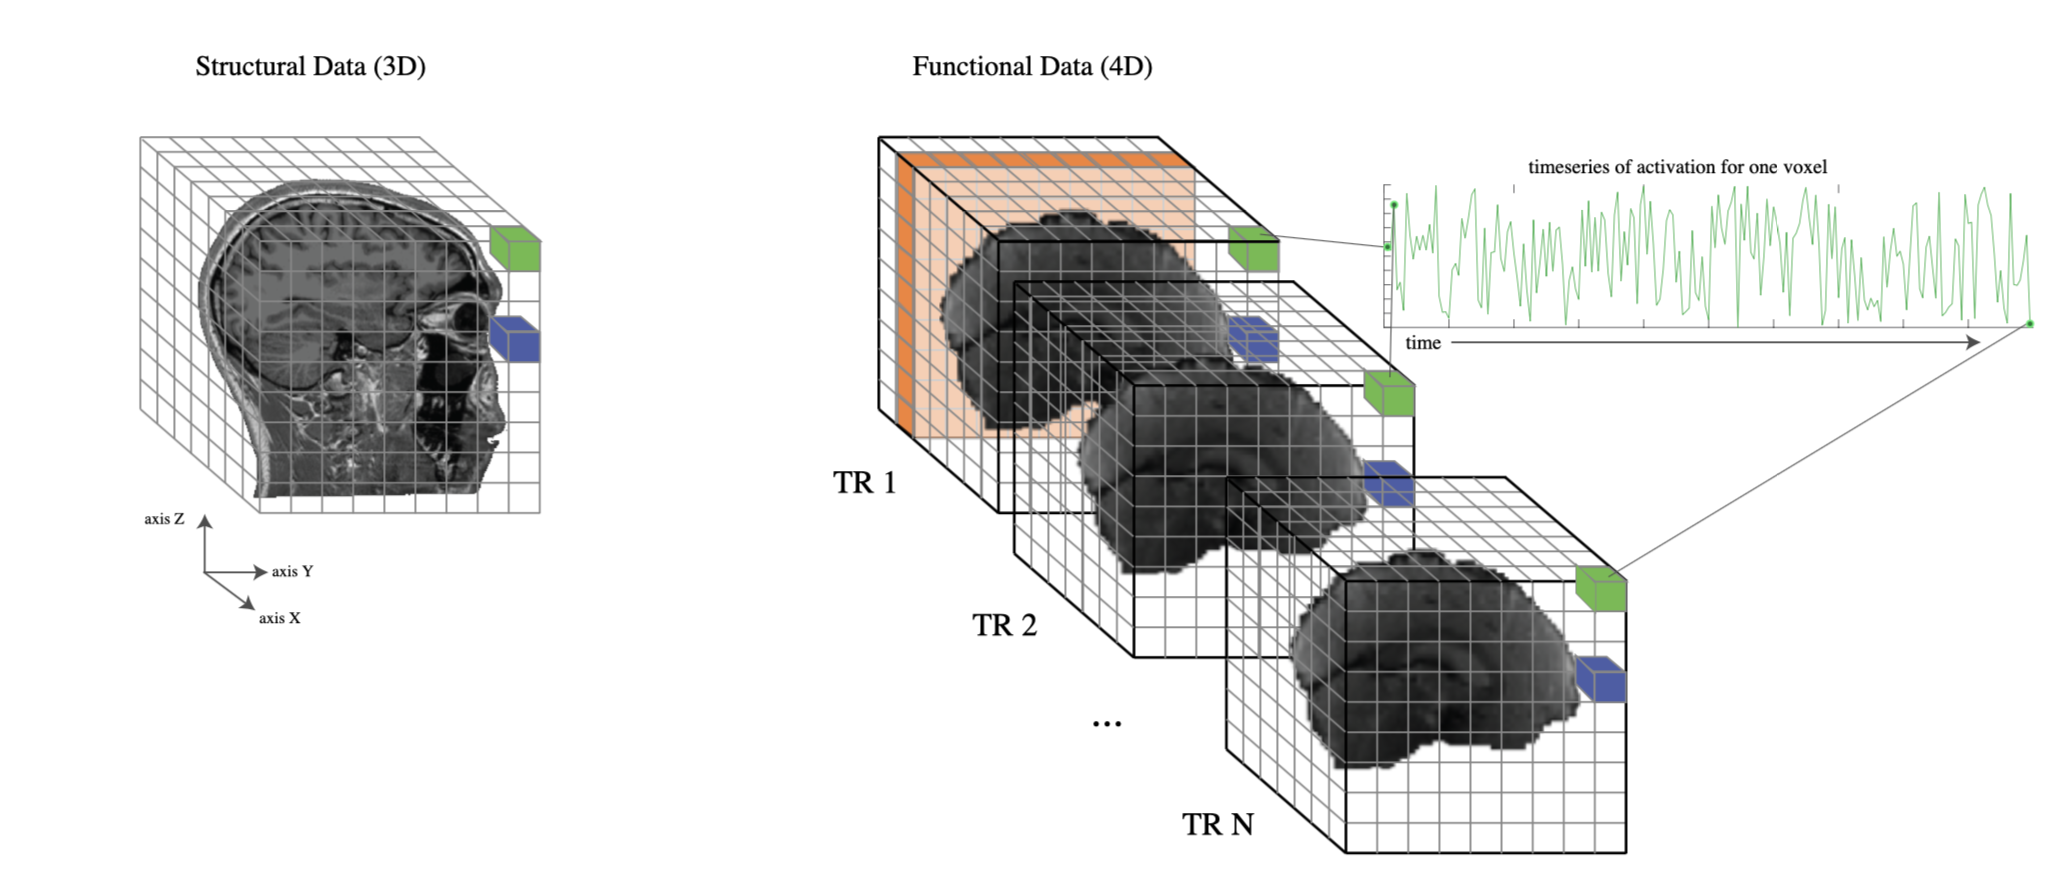

In [3]:
Image(filename = "./assets/voxel.png", width=1000, height=800)

**voxel:** A three-dimensional pixel and the basic unit of spatial measurement in MRI.

**volume:** The three dimensional array covering the brain. Volumes are composed of voxels
All volume files contain both meta-data and voxels. The meta-data is just a set of information about the file’s contents while the voxels are a 3D or 4D array of values.

**slice:** A two-dimensional 'view' of the three-dimensional volume obtained by taking all of the elements in two of the dimensions for a fixed location in the third dimension.

**Timecourse or Timeseries:** a set of numbers representing a measurement (like BOLD activation) taken over time.

Here are the most typical file formats of neuroimaging data:
1) *DICOM (.dcm, .ima)* \
2) *NIFTI (.nii/nii.gz, gii.gz)* \
3) *MGH (.mgh, .mgz)* \
4) Custom (.dtseries, .label, .surf)

#### DICOM file format

In [5]:
# Single slice of Brain MRI

dcm_path = '/workspace/data/Brats_kaggle/DICOM/00008/T1w/'
g = glob(os.path.join(dcm_path, '*'))
!tree ./data/Brats_kaggle/DICOM/ --filelimit 2

# Print out the first 5 file names to verify we're in the right folder.

print('Total of %d DICOM images.\nFirst 5 filenames:' % len(g))
print('Standart DICOM directory tree: \n')
print('\n'.join(g[:]))

./data/Brats_kaggle/DICOM/
├── 00008 [4 entries exceeds filelimit, not opening dir]
└── 00009 [4 entries exceeds filelimit, not opening dir]

2 directories, 0 files
Total of 30 DICOM images.
First 5 filenames:
Standart DICOM directory tree: 

/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-24.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-21.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-5.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-4.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-1.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-14.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-27.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-7.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-3.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-29.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-12.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-19.dcm
/workspace/data/Brats_kaggle/DICOM/00008/T1w/Image-6.dcm
/workspac

Common MRI DICOM sctructure

Dimension of one dcm file: (512, 512)


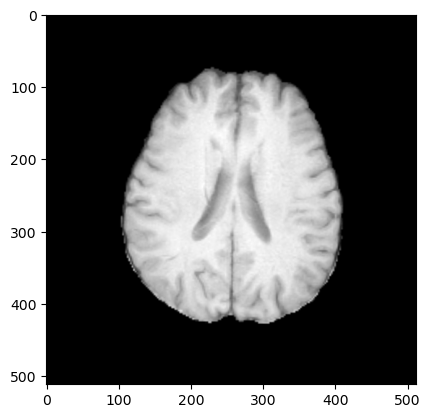

In [8]:
dcm_file = pydicom.dcmread(os.path.join(dcm_path, 'Image-20.dcm'))
plt.imshow(dcm_file.pixel_array, cmap='gray', origin='upper')
rows = int(dcm_file.Rows)
cols = int(dcm_file.Columns)
print('Dimension of one dcm file:', dcm_file.pixel_array.shape)
plt.show()

**Lets stack all DICOM's and plot em aall:**

In [11]:
def load_scan(path):
    slices = [pydicom.dcmread(dcm_path + '/' + s) for s in os.listdir(dcm_path) if '.dcm' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    
    image = np.stack([s.pixel_array for s in slices])
    return np.array(image)


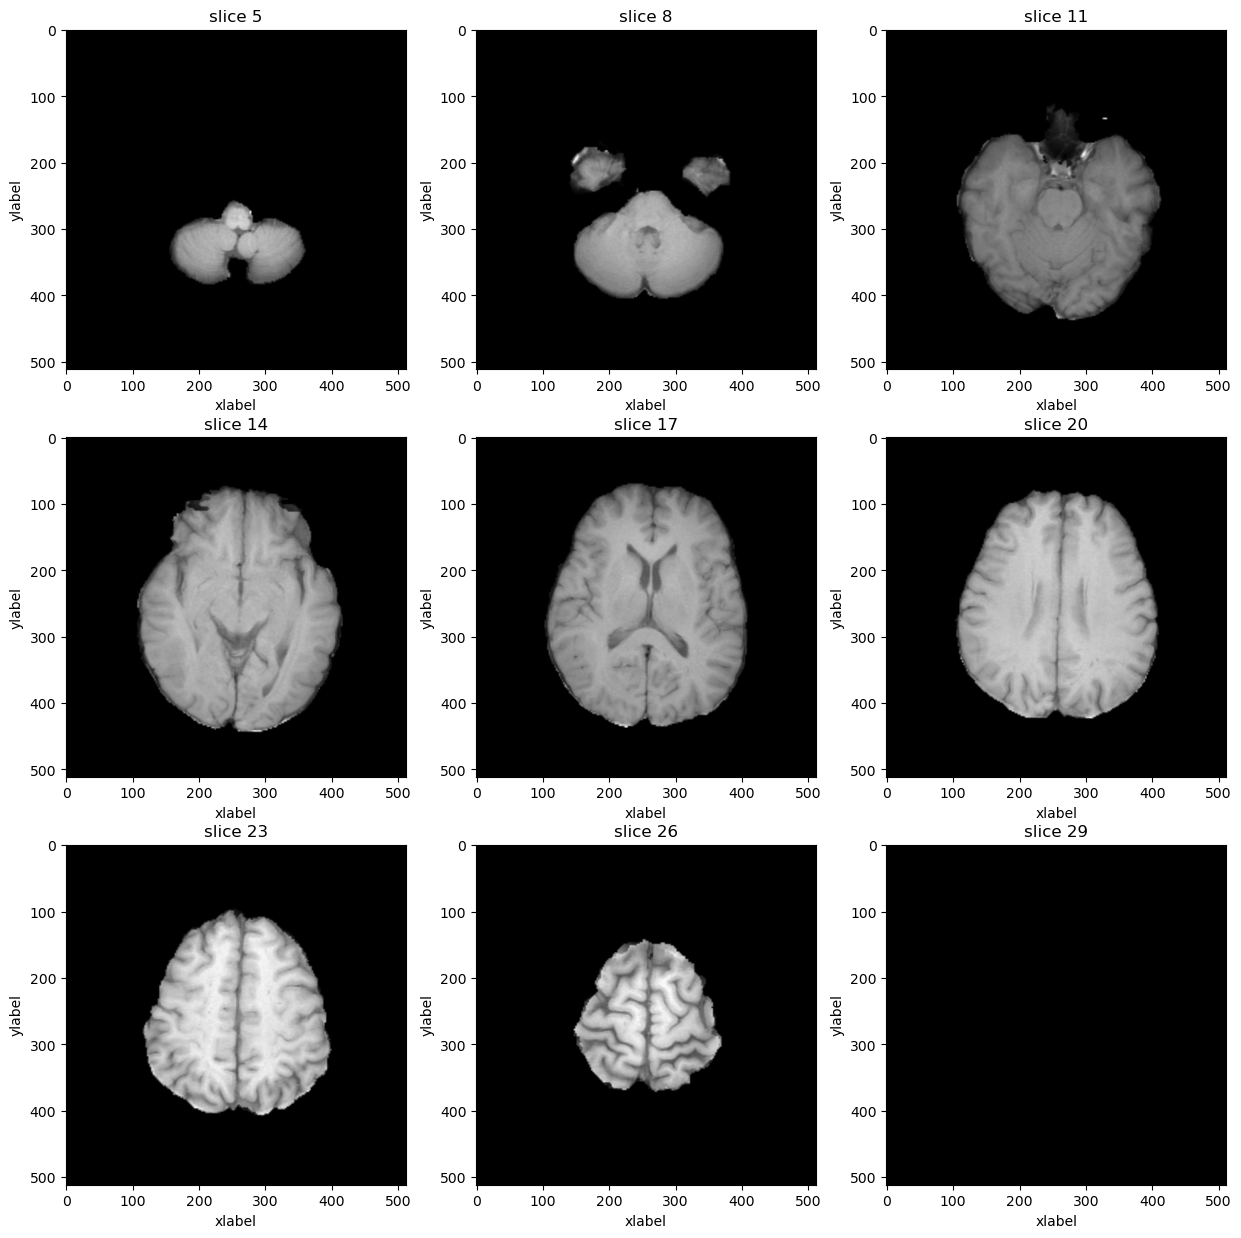

In [12]:
dcm_stack = load_scan(dcm_path)
rows=3
cols=3
start_with=5
show_every=3
fig,ax = plt.subplots(rows,cols,figsize=[15,15])
for i in range(rows*cols):
    ind = start_with + i*show_every
    ax[int(i/rows),int(i % rows)].imshow(dcm_stack[ind],cmap='gray', origin="upper")
    ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
    ax[int(i/rows),int(i % rows)].set_xlabel('xlabel')
    ax[int(i/rows),int(i % rows)].set_ylabel('ylabel')
plt.show()


**DICOM Headers**

Another good way to look at the meta-data in a volume file is to load it with the relevant programming environment and examine the data-structures there. Here are a few examples.
Accordingly, we need to be able to, at a minimum, store some amount of information about the coordinate system employed in any MRI volume file, and ideally some amount of information about how to precisely align the brain to some standard orientation.

In [13]:
pat_name = dcm_file.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient id.......:", dcm_file.PatientID)
print("Modality.........:", dcm_file.Modality)
print("Rows.............:", dcm_file.Rows)
print("Columns..........:", dcm_file.Columns)
print("Pixel Spacing....:", dcm_file.PixelSpacing)
print("Slide Thickness.:", dcm_file.SliceThickness)
print("Patient Position.:", dcm_file.PatientPosition)

Patient id.......: 00008
Modality.........: MR
Rows.............: 512
Columns..........: 512
Pixel Spacing....: [0.449200004339218, 0.449200004339218]
Slide Thickness.: 5
Patient Position.: HFS


In [14]:
#dcm_header = pydicom.dcmread(dcm_file)
dcm_file

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.12619773221542827483556664577340178568
(0008, 0050) Accession Number                    SH: '00008'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'T1w'
(0010, 0010) Patient's Name                      PN: '00008'
(0010, 0020) Patient ID                          LO: '00008'
(0018, 0023) MR Acquisition Type                 CS: '2D'
(0018, 0050) Slice Thickness                     DS: '5.0'
(0018, 0081) Echo Time                           DS: None
(0018, 0083) N

#### Data manipulations

Assume that you recieved new dicom from hospital or downloaded challenge data and you need to convert to convinient NIFTI, let's review the tool distinctive from simple one represented above:

**dcm2niix** \
Robust .dcm to nii/nii.gz converter. Params *%i* *%n* *%p* stands for patient ID, subject name, protocol name DICOM header keys. Try to run with params %p_%t_%s \

https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage#General_Usage

In [15]:
!dcm2niix -o /workspace/ -f %i_%n_%p -z y ./data/Brats_kaggle/DICOM/00008/T1w

Chris Rorden's dcm2niiX version v1.0.20240202  GCC5.4.0 x86-64 (64-bit Linux)
Found 30 DICOM file(s)
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-24.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-21.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-5.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-4.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-1.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-14.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/Brats_kaggle/DICOM/00008/T1w/Image-27.dcm'
DICOM appears corrupt: first group:element should be 0x0002:0x0000 './data/B

Plotting results of convertation:

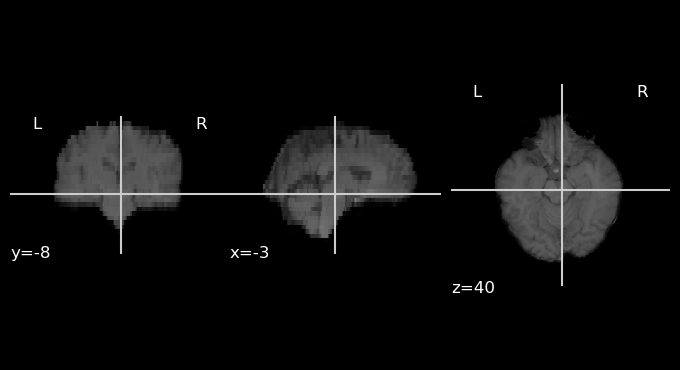

In [16]:
plotting.plot_anat('/workspace/00008_00008_T1w.nii.gz', bg_img=None)

#### Nifti File Format

The Neuroimaging Informatics Technology Initiative (nifti) is format to store radiological information, the first three dimensions are reserved to define the three spatial dimensions — x, y and z —, while the fourth dimension is reserved to define the time points — t. The remaining dimensions, from fifth to seventh, are for other uses. The fifth dimension, however, can still have some predefined uses, such as to store voxel-specific distributional parameters or to hold vector-based data.

In [17]:
nii_file = nib.load('/workspace/00008_00008_T1w.nii.gz')

#### Nifti Header

In [18]:
nii_header = nii_file.header
print("Image dimensions...........................:", nii_header['dim'])
print("Voxel size and time interval...............:", nii_header['pixdim'])
print("Slice Order................................:", nii_header['slice_code'])
print("Human readable text........................:", nii_header['descrip'])
print("Three rows of sform affine transformation..:"'\n', nii_header['srow_x'],'\n', nii_header['srow_y'],'\n', nii_header['srow_z'])


Image dimensions...........................: [  3 512 512  30   1   1   1   1]
Voxel size and time interval...............: [-1.        0.4492    0.4492    4.999977  0.        0.        0.
  0.      ]
Slice Order................................: 0
Human readable text........................: np.bytes_(b'TE=0;Time=0.000')
Three rows of sform affine transformation..:
 [-4.4895884e-01 -7.2160424e-03  1.4277743e-01  1.0917840e+02] 
 [-6.5540536e-03  4.4856551e-01  2.5544879e-01 -1.1994498e+02] 
 [ 1.3177733e-02 -2.2750149e-02  4.9914060e+00 -2.0237373e+01]


#### MGH File Format

**MGH File Format** is a default format of *freesurfer* preprocessing software. That can do the following

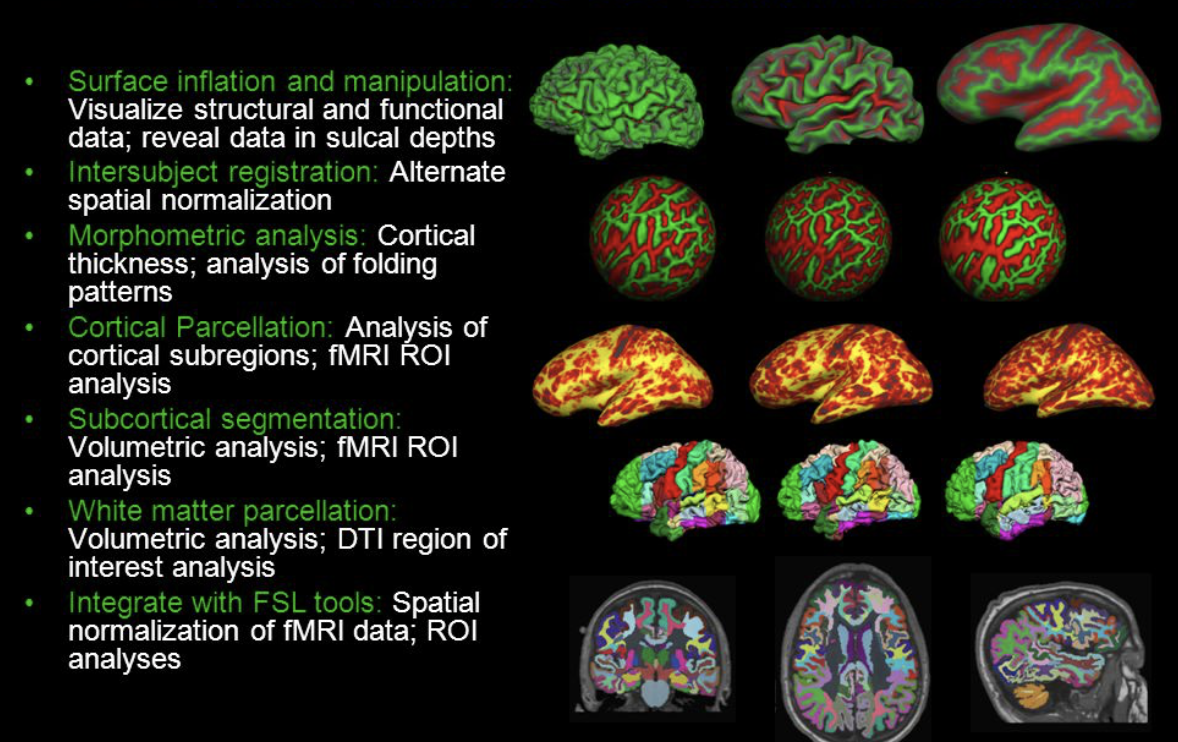

In [19]:
Image(filename = "./assets/freesurfer.png", width=1000, height=800)

In [21]:
mgh_file = mgh.load('./data/freesurfer_preproc/100206/mri/T1.mgz')
mgh_file.get_fdata().shape

(256, 256, 256)

In [22]:
# Define plot function
def show_slices(image, axis1="x", axis2="y", axis3="z"):
    slice_0 = image[round(len(image[0])/2), :, :]
    slice_1 = image[:, round(len(image[1])/2), :]
    slice_2 = image[:, :, round(len(image[2])/2)]
    image = ([slice_0, slice_1, slice_2])
    fig, axes = plt.subplots(1, len(image), figsize=[15,15])
    for i, slice in enumerate(image):
        axes[i].imshow(slice.T, cmap="gray", origin="upper")
        axes[0].set(xlabel=axis2, ylabel=axis3)
        axes[1].set(xlabel=axis1, ylabel=axis3)
        axes[2].set(xlabel=axis1, ylabel=axis2)
    plt.show()

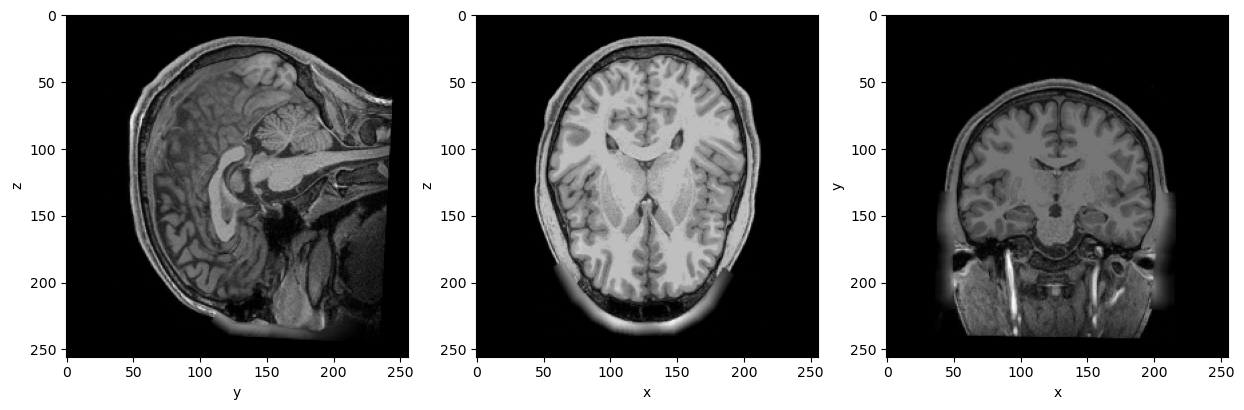

In [23]:
mgh_image = np.array(mgh_file.dataobj).astype(np.float64)
show_slices(mgh_image)

**MGH Header**

In [24]:
mgh_header = mgh_file.header
print("Image dimensions........:", mgh_header['dims'])
print("Orientation matrix...: "'\n', mgh_header.get_affine())

Image dimensions........: [256 256 256   1]
Orientation matrix...: 
 [[-1.0000000e+00  1.8626451e-09 -4.0745363e-10  1.2723160e+02]
 [ 2.9103830e-10 -3.7252903e-09  1.0000001e+00 -8.1819077e+01]
 [ 1.8626451e-09 -1.0000000e+00  0.0000000e+00  1.3774704e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


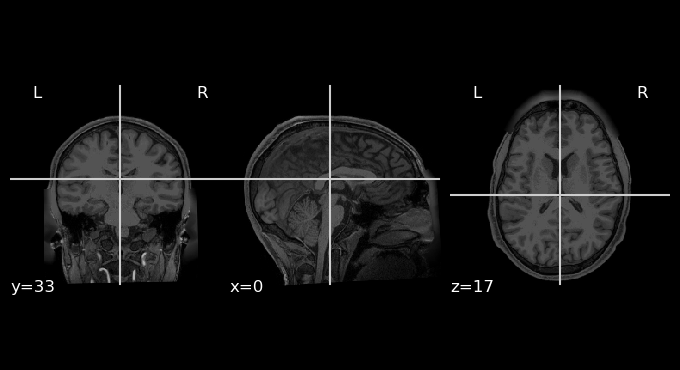

In [25]:
plotting.plot_anat(mgh_file, bg_img=None)

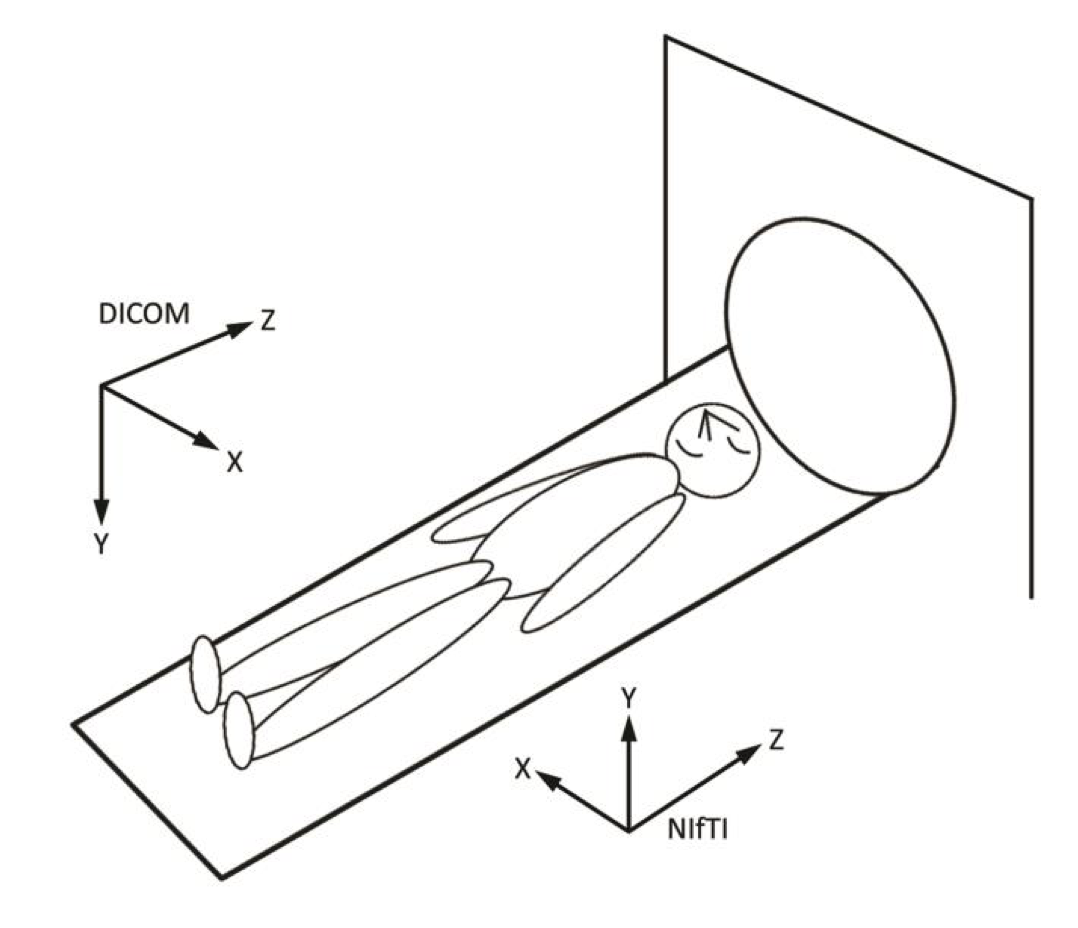

In [26]:
Image(filename = "./assets/Orientation.png", width=600, height=800)

DICOM patient coordinate and Nifti coodrinate system when Patient is Head First Supine. The arrows of axes indicate the positive directions, LPS for DICOM and RAS for Nifti. For Dicom images, the origin (0,0,0) refers to magnet isocenter.     



*Voxel size* and *Pixel spacing* are important as we for preprocessing we can use only isomorphic voxel

**BIDS** Brain Imaging Data Structure. \
Simplify representation of DICOM neuroimaging data and grants huge advantages for experiments and version control of dataset. Moreover, reduces dataset storage range.

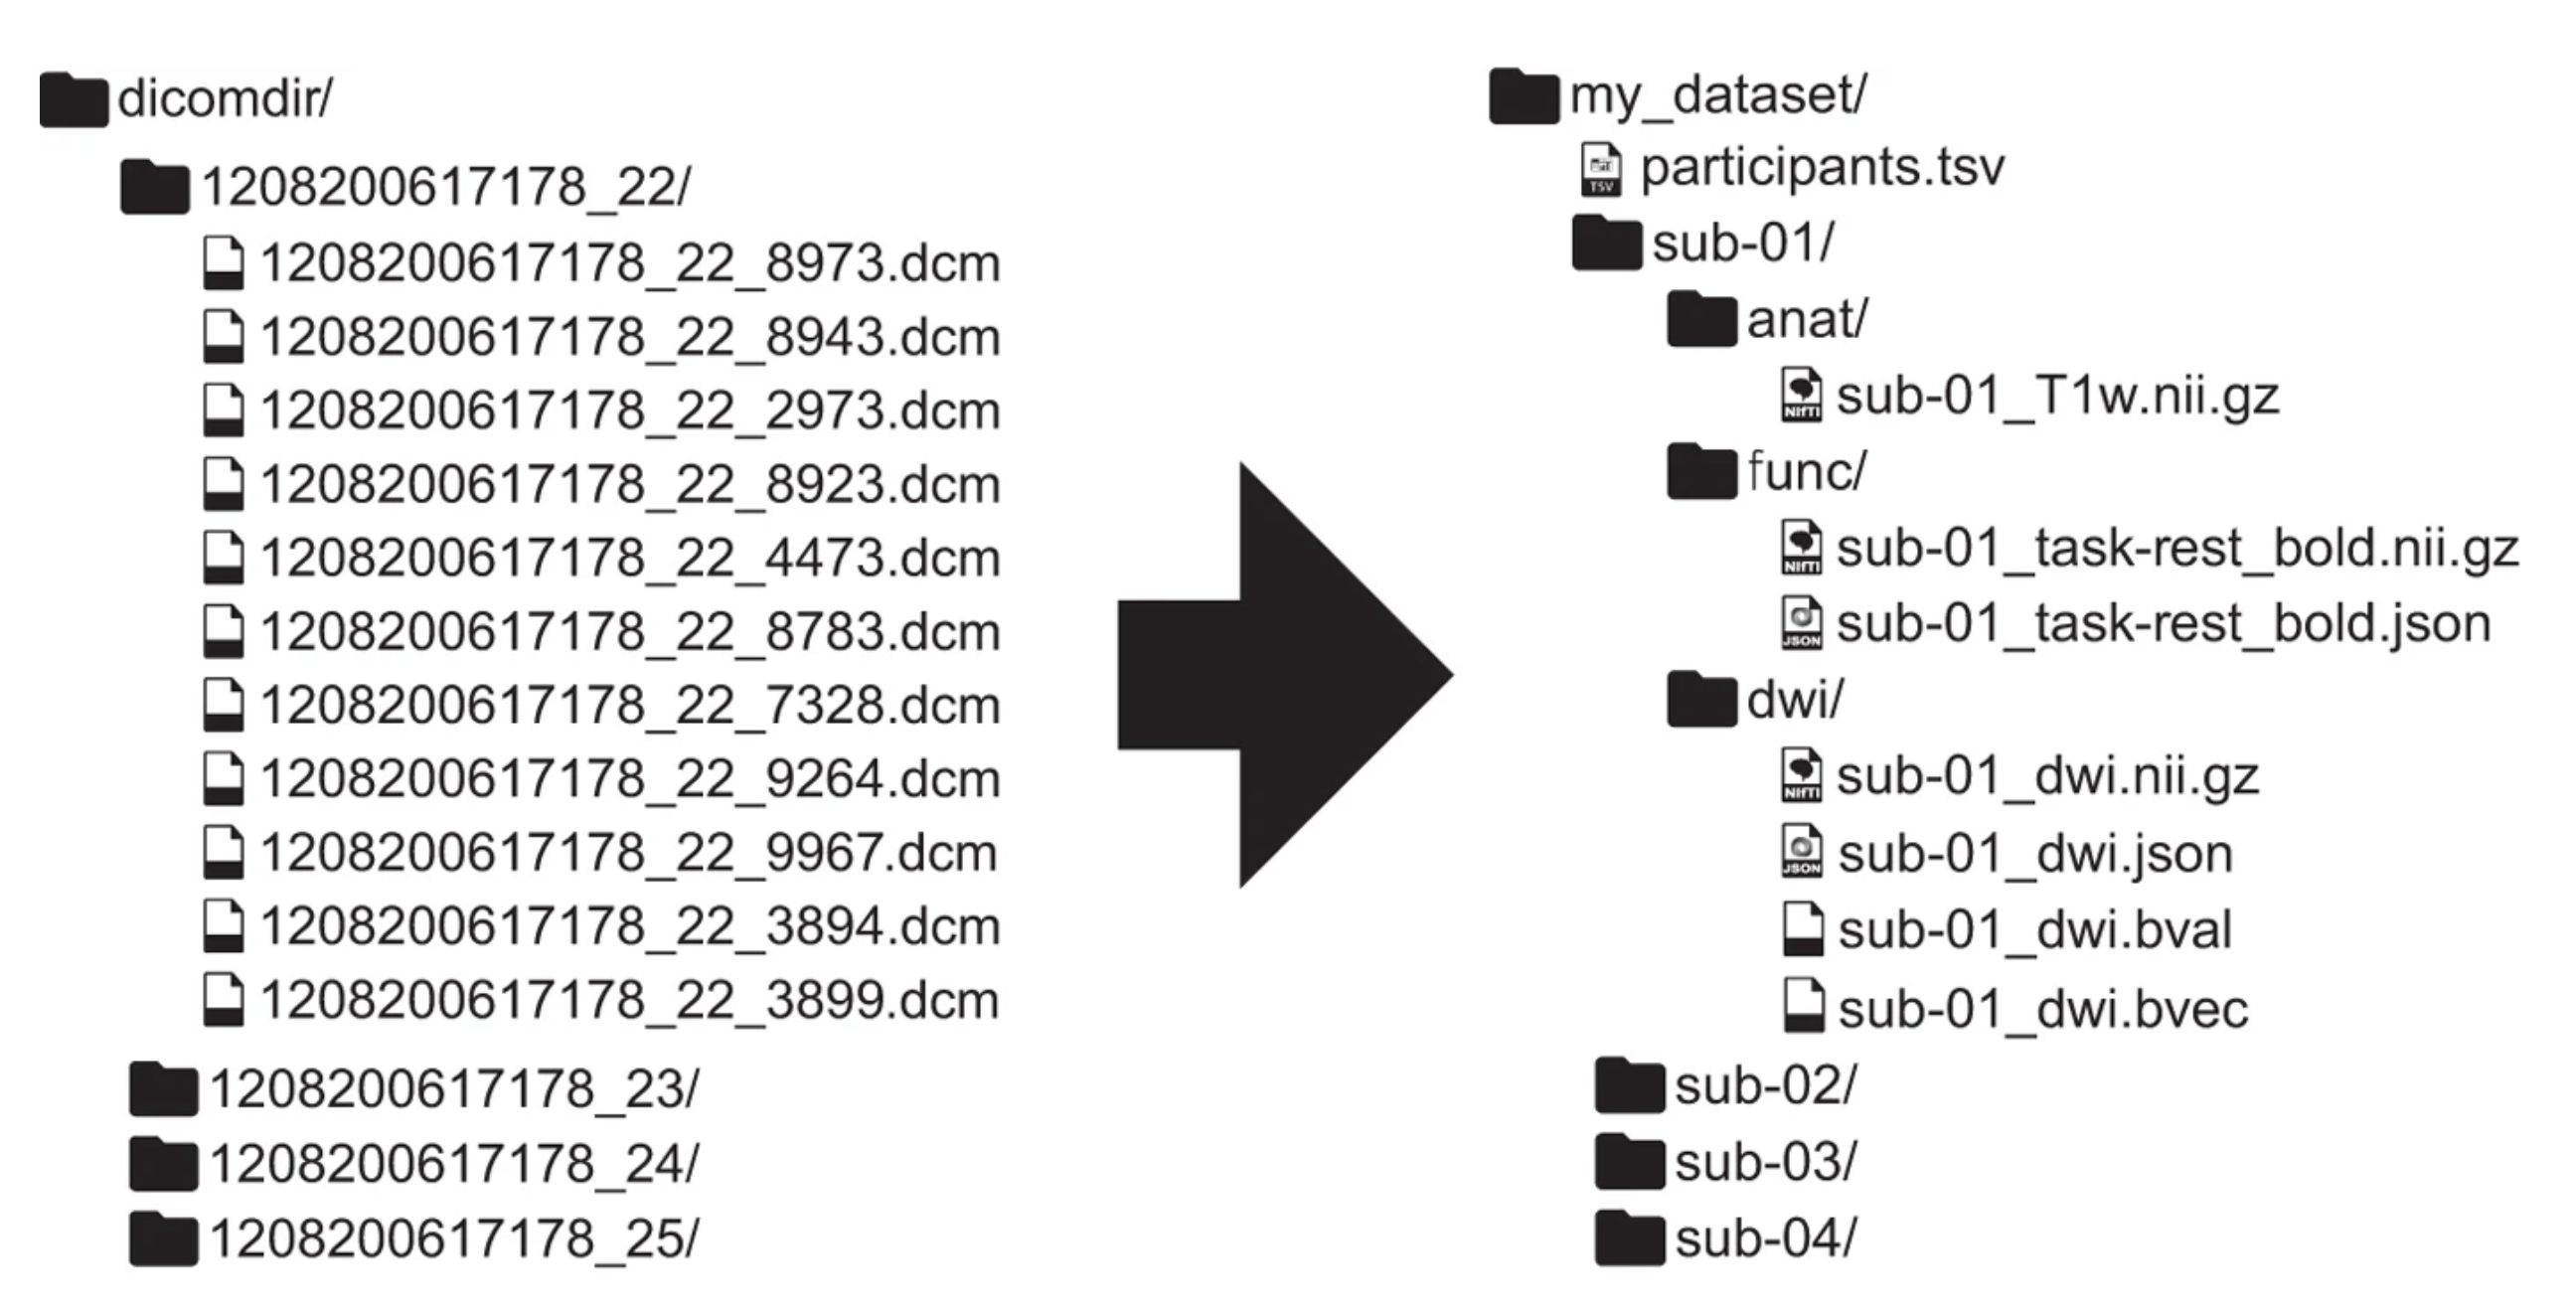

In [27]:
Image(filename = "./assets/BIDS.png", width=800, height=800)

There is a few robust DICOM converters:
> **HeudiConv**

> **dcm2bids**

They both use DICOM headers, to distinquish sequence protocols. So fully anonomized DICOMs can't be converted using this software.
Let's look how *heudiconv* runs:
First you should implement heudiconv.py.
The only required function for a heuristic, *infotodict* is used to both define the conversion outputs and specify the criteria for scan to output association. Conversion outputs are defined as keys, a tuple consisting of a template path used for the basis of outputs, as well as a tuple of output types. Valid types include nii, nii.gz, and dicom.

In [28]:
!/opt/miniconda-latest/envs/neuro/bin/heudiconv -d /workspace/data/Brats_kaggle/DICOM/{subject}/*/* \
    -f /workspace/heuristic.py \
    -s 00008 \
    -c dcm2niix \
    -b --overwrite \
    -o /workspace/BIDS > /workspace/heudiconv_log 2>&1

Heudiconv output BIDS directory tree:

In [29]:
!tree /workspace/BIDS

/workspace/BIDS
├── CHANGES
├── dataset_description.json
├── participants.json
├── participants.tsv
├── README
├── scans.json
└── sub-00008
    ├── anat
    │   ├── sub-00008_acq-Flair_T1w.json
    │   ├── sub-00008_acq-Flair_T1w.nii.gz
    │   ├── sub-00008_acq-T1Wce_T1w.json
    │   ├── sub-00008_acq-T1Wce_T1w.nii.gz
    │   ├── sub-00008_acq-T1W_T1w.json
    │   ├── sub-00008_acq-T1W_T1w.nii.gz
    │   ├── sub-00008_acq-T2W_T1w.json
    │   └── sub-00008_acq-T2W_T1w.nii.gz
    └── sub-00008_scans.tsv

2 directories, 15 files


## Visualization

We have already looked at visualisation using `plot_anat` from nilearn. Let's look at other interesting methods to visualize MRI data.

Plot any NIFTI file from BIDS/anat directory using `plot_anat` and filepath.

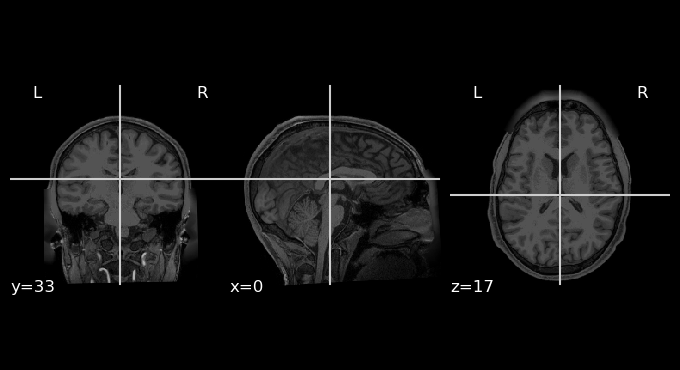

In [52]:
### YOUR CODE HERE
data_path = './data/freesurfer_preproc/100206/mri/T1.mgz'


Nilearn plotting functions are very flexible and allow us to easily customize our plots. Let's see.

In [46]:
plotting.plot_anat?

Signature:
plotting.plot_anat(
    anat_img=<MNI152Template>,
    cut_coords=None,
    output_file=None,
    display_mode='ortho',
    figure=None,
    axes=None,
    title=None,
    annotate=True,
    threshold=None,
    draw_cross=True,
    black_bg='auto',
    dim='auto',
    cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f4b4c113fd0>,
    colorbar=False,
    cbar_tick_format='%.2g',
    radiological=False,
    vmin=None,
    vmax=None,
    **kwargs,
)
Docstring:
Plot cuts of an anatomical image.

By default 3 cuts: Frontal, Axial, and Lateral.

Parameters
----------
anat_img : Niimg-like object, default=MNI152TEMPLATE
    See :ref:`extracting_data`.
    The anatomical image to be used as a background. If None is
    given, nilearn tries to find a T1 template.

cut_coords : None, a :obj:`tuple` of :obj:`float`, or :obj:`int`, optional
    The MNI coordinates of the point where the cut is performed.

        - If `display_mode` is `'ortho'` or `'tiled'`, this should
   

Try to change parameters `display_mode` and `cut_coords`

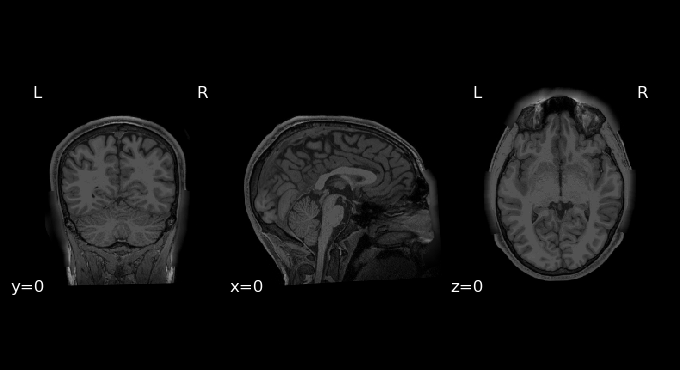

In [47]:
plotting.plot_anat(data_path, draw_cross=False)

We can plot some features or segmentation above the brain image.

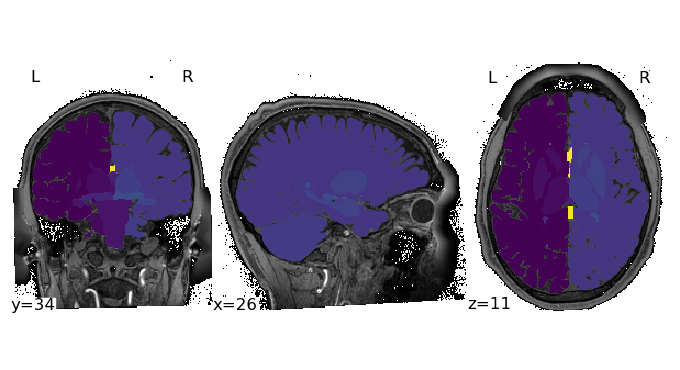

In [55]:
plotting.plot_img('data/freesurfer_preproc/100206/mri/aseg.mgz', bg_img = data_path, draw_cross=False, threshold=0.01)

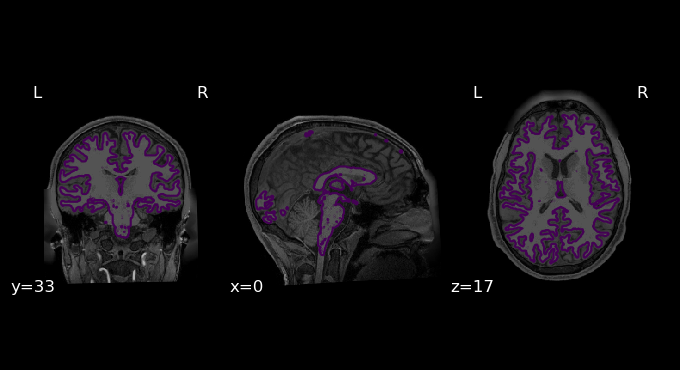

In [60]:
img = plotting.plot_anat(data_path, draw_cross=False)
img.add_contours('data/freesurfer_preproc/100206/mri/wm.mgz', levels=[0.5])

In [4]:
!rm -r /workspace/BIDS/*
!rm -r /workspace/BIDS/.heudiconv